In [3]:
import vaex
import numpy as np
import os
import copy
import matplotlib
from matplotlib.pyplot import figure, show, ylim
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy import interpolate
import pandas as pd
import time
import matplotlib as mpl

from dustmaps.bayestar import BayestarQuery
from dustmaps.sfd import SFDQuery
from dustmaps.gaia_tge import GaiaTGEQuery
import astropy.units as u
from astropy.coordinates import SkyCoord

from matplotlib.gridspec import GridSpec

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

## Initial settings

In [4]:
## --------------------------------------------------------------
## set paths for relevant files

## produced by the first part of the "prepare training" code, but any spectroscopic sample with the following columns should work:
## 'survey_neverempty','program_neverempty','ra','dec', 'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR'

train_all = '../catalogues/TrainingSample_may2023_v4+CaHK.csv'

## folder with the extinction polynomial files
extpolfolder = '../extpol/'

   
## --------------------------------------------------------------
## which dustmap to use for the training? options currently implemented are 
## 'bay' for Bayestar19 or 'sfd' for SFD or 'tge' for Gaia TGE (hacked rescaled by 0.7) or 'zero' for no correction

getext_type_train = 'sfd'    

# > Bayestar19 currently takes 1/parallax for the distance, and if not available d=10kpc. 


## --------------------------------------------------------------
## set dwarfs/giants limits

loggcut = 3.9            # logg cut for giants/dwarfs
teffcut = 5800           # above this Teff include all stars for both giant and dwarf selections


## --------------------------------------------------------------
## CCD shape (for plotting)

bf = 2.5       # (CaHK-G) - bf*(BP-RP)


In [5]:
sfd = SFDQuery()
if getext_type_train == 'bay':
    bayestar = BayestarQuery(version='bayestar2019')
elif getext_type_train == 'tge':
    tge = GaiaTGEQuery()

In [6]:
## Function to correct for extinction

def polynomial_model(TnormA0feh, const, a, b, c, a2, b2, c2, ab, ac, bc, a3, b3, c3, a2b, ab2, a2c, ac2, b2c, bc2, abc):

    # a is factor for T_norm; b is factor for A0; c is factor for [Fe/H]
    # T_norm = Teff/5040

    Tnorm, A0, feh = TnormA0feh

    val1 = const + a*Tnorm + b*A0 + c*feh + a2*Tnorm**2 + b2*A0**2 + c2*feh**2 + a3*Tnorm**3 + b3*A0**3 + c3*feh**3
    val2 = ab*Tnorm*A0 + ac*Tnorm*feh + bc*A0*feh
    val3 = a2b*Tnorm**2*A0 + ab2*Tnorm*A0**2 + a2c*Tnorm**2*feh + ac2*Tnorm*feh**2 + b2c*A0**2*feh + bc2*A0*feh**2
    val4 = abc*Tnorm*A0*feh

    return val1 + val2 + val3 + val4

df_dwarf = pd.read_csv(extpolfolder+'final_dwarf_polynomial_parameters_anke+v.csv')
df_giant = pd.read_csv(extpolfolder+'final_giant_polynomial_parameters_anke+v.csv')

fit_parameters_dwarf = np.array(df_dwarf)[:,2:22]
fit_parameters_giant = np.array(df_giant)[:,2:22]

sfdfac = 0.86
RV = 3.1

# Read data

In [7]:
df_TS_all = pd.read_csv(train_all)
df_TS_all = df_TS_all[df_TS_all.ra < 360]

df_TS_all = df_TS_all.drop_duplicates(subset='source_id', keep='first')

## at the time of creating the training sample Pvar was not available for all training sample stars, so an estimate was used
## (varX = Fernandez-Alvar et al. (2021) cut, varX2 = close to Pvar = 0.5 for G > 15)
df_TS_all['varpar'] =  np.sqrt(df_TS_all.phot_g_n_obs)/(df_TS_all.phot_g_mean_flux/df_TS_all.phot_g_mean_flux_error)
df_TS_all['varX']   = 2**(df_TS_all.phot_g_mean_mag - 16.0)/800.0 * np.maximum(df_TS_all.phot_g_mean_mag - 15.0, 0) + 0.015
df_TS_all['varX2']  = 2**(df_TS_all.phot_g_mean_mag - 16.0)/650.0 * np.maximum(df_TS_all.phot_g_mean_mag - 15.0, 0) + 0.01

df_TS_all = df_TS_all.assign(CaHK = df_TS_all.merged_CaHK)
df_TS_all = df_TS_all.assign(e_CaHK = df_TS_all.merged_d_CaHK)
df_TS_all = df_TS_all.assign(flag = df_TS_all.merge_flag)

print(len(df_TS_all), len(df_TS_all[df_TS_all.feh_lit < -2.0]))

133258 8111


# Giants & dwarfs selections + extinction

In [8]:
for subset in ['giants','dwarfs']:
    print(subset)
    
    if subset == 'giants':
        
        ## get the appropriate extinction polynomial
        model_g = fit_parameters_giant[0]
        model_bp = fit_parameters_giant[1]
        model_rp = fit_parameters_giant[2] 
        model_cahk = fit_parameters_giant[3] 
        model_a0av = fit_parameters_giant[4] 
        
        ## giants selection
        df_TS = df_TS_all[( ((df_TS_all.logg_lit < loggcut) | (df_TS_all.survey_neverempty == 'Aguado19'))
                           & (df_TS_all.logg_lit > -1) 
                   & ((df_TS_all.teff_lit > 4500) | (df_TS_all.logg_lit < 3.0))) 
                         ]
        
        yaxlim = -99.9
        
    elif subset == 'dwarfs':
        
        ## get the appropriate extinction polynomial
        model_g = fit_parameters_dwarf[0]
        model_bp = fit_parameters_dwarf[1]
        model_rp = fit_parameters_dwarf[2]  
        model_cahk = fit_parameters_dwarf[3] 
        model_a0av = fit_parameters_dwarf[4] 
        
        ## dwarfs selection
        df_TS = df_TS_all[(df_TS_all.survey_neverempty != "APOGEE") 
                  & ( ((df_TS_all.logg_lit > loggcut) | (df_TS_all.teff_lit > teffcut)) )
           ]
        
        ## Cut out metal-rich stars that are above this value in the CCD to clean up a feature around BP-RP = 1.25
        yaxlim = -1.25
    
    ## --------------------------
    ## EXTINCTION CORRECTION ON TRAINING SAMPLE
    ## --------------------------

    coords_train = SkyCoord(df_TS.ra*u.deg, df_TS.dec*u.deg, frame='icrs')
    
    Tnorm = df_TS['teff_lit'].to_numpy()/5040.
    feh = df_TS['feh_lit'].to_numpy()


    if getext_type_train == 'bay':
        df_TS = df_TS.assign(dist = 1/df_TS.parallax)
        df_TS.loc[(df_TS.dist < 0), 'dist'] = 10.0
        coords_train = SkyCoord(df_TS.ra*u.deg, df_TS.dec*u.deg, frame='icrs', distance=df_TS.dist.values*u.kpc)

        ebv = bayestar(coords_train, mode='median')

        A0AV = polynomial_model((Tnorm, RV*sfdfac*ebv, feh), *model_a0av)
        A0val = RV * A0AV * ebv * sfdfac

        df_TS = df_TS.assign(a0 = A0val)

    elif getext_type_train == 'sfd':
        ebv_sfd = sfd(coords_train)

        A0AV = polynomial_model((Tnorm, RV*sfdfac*ebv_sfd, feh), *model_a0av)
        A0val = RV * A0AV * ebv_sfd * sfdfac

        df_TS = df_TS.assign(a0 = A0val)
        df_TS = df_TS.assign(ebv_sfd = ebv_sfd)

    elif getext_type_train == 'tge':

        A0val = tge(coords_train) *0.7  # fudge factor to get it on the same scale as SFD/Bayestar
        df_TS = df_TS.assign(a0 = A0val)

    elif getext_type_train == 'zero':

        A0val = np.zeros(len(coords_train))
        df_TS = df_TS.assign(a0 = A0val)

    
    ## extinction coefficients & correction
    kg_gaia = polynomial_model((Tnorm, A0val, feh), *model_g)
    kbp_gaia = polynomial_model((Tnorm, A0val, feh), *model_bp)
    krp_gaia = polynomial_model((Tnorm, A0val, feh), *model_rp)
    kcahk = polynomial_model((Tnorm, A0val, feh), *model_cahk)

    df_TS = df_TS.assign(G_0 = df_TS.phot_g_mean_mag - kg_gaia*A0val)
    df_TS = df_TS.assign(BP_0 = df_TS.phot_bp_mean_mag - kbp_gaia*A0val)
    df_TS = df_TS.assign(RP_0 = df_TS.phot_rp_mean_mag - krp_gaia*A0val)
    df_TS = df_TS.assign(CaHK_0 = df_TS.CaHK - kcahk*A0val)

    ## quality cuts
    df_TS_cuts = df_TS[((df_TS.e_feh_lit<0.3) | (df_TS.program_neverempty == 'hr')) & (df_TS.feh_lit >= -5)
               & (df_TS.e_CaHK<=0.05)
               & (df_TS.flag == -1)     # for calibration we are just using the -1 CASU flag stars
               & (df_TS.ruwe<1.4)
               & (df_TS.varpar < df_TS.varX2)
               & ~( (df_TS.feh_lit > -1.0) & 
                         ((df_TS['CaHK_0'] - df_TS['G_0']) - 2.7*(df_TS['BP_0'] - df_TS['RP_0']) < yaxlim) )
               ]
    
    ## keep only low E(B-V) (<0.1) stars in the training sample
    if getext_type_train == 'tge':
        df_TS_cuts = df_TS_cuts[(df_TS_cuts.a0 < 0.3)]
    else:
        df_TS_cuts = df_TS_cuts[(df_TS_cuts.ebv_sfd < 0.1)]

    ## save to file
    df_TS_cuts.to_csv(train_all[:-4]+'_{}.csv'.format(subset))


giants
dwarfs


# Fit [Fe/H] = 0.0 line

This line is used to create the bottom edge of the Photometric Metallicity Grid in the main code

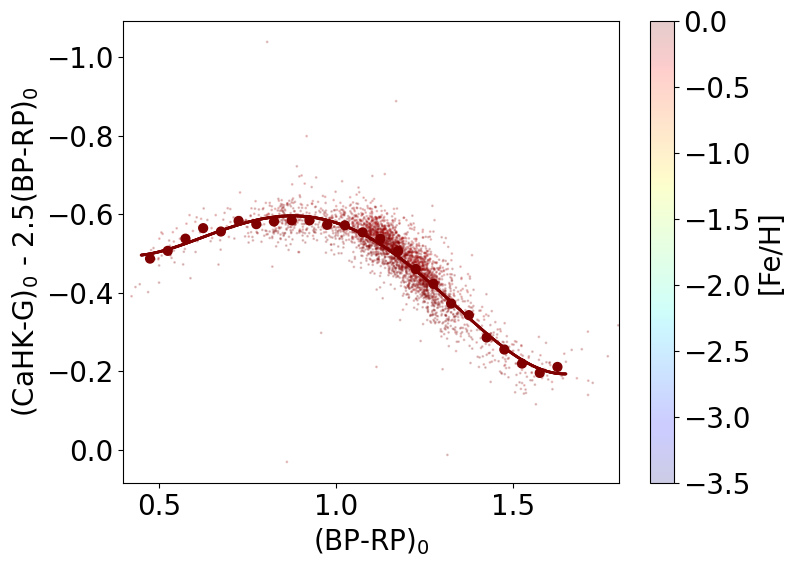

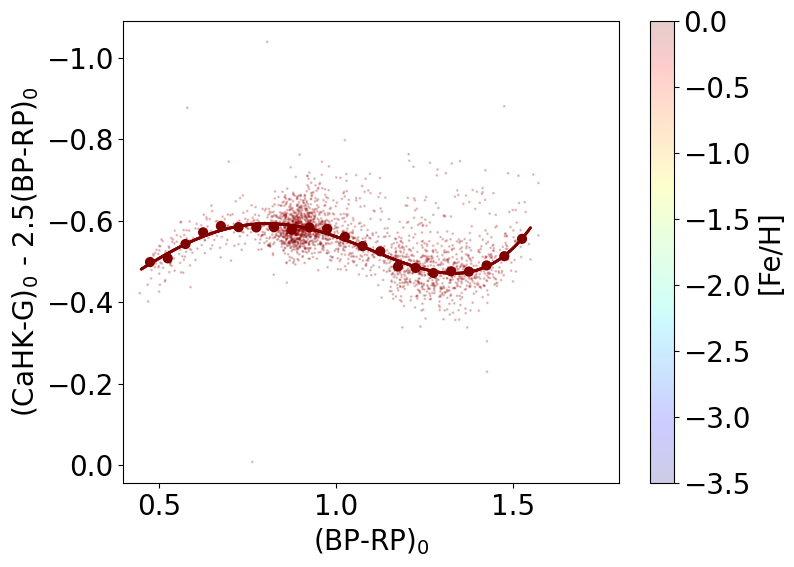

In [41]:
from scipy import stats

for subset in ['giants','dwarfs']:

    TSsel1 = pd.read_csv(train_all[:-4]+'+CaHK_{}.csv'.format(subset))

    plt.figure(figsize=(8,6))

    ## Plotting settings: Min and max for the colour bars
    maxcol = 0.0
    mincol = -3.5

    ## Points to fit polynomial to settings
    bin_size = 0.05; min_edge = 0.4; max_edge = 1.7001

    ## ff is the metallicity for which to fit the polynomial (default is only solar metallicity)
    for ff in [0.0]:

        ## order of the polynomial
        polyorder = 3 if ff < -1.7 else 4

        ## select stars within +/- 0.15 dex of the chosen metallicity
        TSsel1_ff = TSsel1[(TSsel1.feh_lit > ff - 0.15) & (TSsel1.feh_lit <= ff + 0.15)]
        
        ## plot the stars in the training sample in this metallicity range
        plt.scatter(TSsel1_ff['BP_0'] - TSsel1_ff['RP_0'], (TSsel1_ff['CaHK_0'] - TSsel1_ff['G_0']) - (bf)*(TSsel1_ff['BP_0'] - TSsel1_ff['RP_0']), 
                    c = TSsel1_ff.feh_lit, cmap = 'jet', s =1, alpha =0.2, rasterized = True, vmin=mincol, vmax=maxcol)
        if ff == 0.0:
            plt.colorbar(label='[Fe/H]')
        
        ## compute number of stars and median in each colour bin
        xvals = np.arange(min_edge,max_edge, bin_size)
        count = stats.binned_statistic(TSsel1_ff.BP_0 - TSsel1_ff.RP_0 , TSsel1_ff.CaHK_0-TSsel1_ff.G_0 - (bf)*(TSsel1_ff.BP_0 - TSsel1_ff.RP_0), 
                                   statistic='count', bins=xvals)[0]
        mediany = stats.binned_statistic(TSsel1_ff.BP_0 - TSsel1_ff.RP_0, TSsel1_ff.CaHK_0-TSsel1_ff.G_0 - (bf)*(TSsel1_ff.BP_0 - TSsel1_ff.RP_0), 
                                   statistic='median', bins=xvals)[0]

        medianx = xvals[0:-1] + (xvals[1:] - xvals[0:-1])/2

        minnumber = 3
        mediany_nonan = mediany[(np.isnan(mediany) == False) & (count > minnumber) 
                                & (medianx < max_edge - bin_size) & (medianx > min_edge + bin_size)]
        medianx_nonan = medianx[(np.isnan(mediany) == False) & (count > minnumber) 
                                & (medianx < max_edge - bin_size) & (medianx > min_edge + bin_size)]

        ## fit polynomial to the medians
        polypar = np.polyfit(medianx_nonan, mediany_nonan, polyorder)
        p = np.poly1d(polypar)

        x_poly = np.arange(min(medianx_nonan)-bin_size/2, max(medianx_nonan)+bin_size/2, 0.001)
        y_poly = p(x_poly)

        ## plot medians and fitted polynomial
        plt.scatter(medianx_nonan, mediany_nonan, c=ff*np.ones(len(mediany_nonan)), cmap='jet', vmin=mincol, vmax=maxcol, s=40)
        plt.scatter(x_poly, y_poly, s=1, c=ff*np.ones(len(y_poly)), cmap='jet', vmin=mincol, vmax=maxcol)

        ## save to file
        if getext_type_train == 'tge':
            np.savetxt('../poly/polypar_{}_{}BPRP_{}_tge.txt'.format(round(ff,1), round(bf,1),subset), polypar)
        else:
            np.savetxt('../poly/polypar_{}_{}BPRP_{}.txt'.format(round(ff,1), round(bf,1),subset), polypar)

    
    plt.xlim(0.4,1.8)
    plt.gca().invert_yaxis()
    plt.xlabel('(BP-RP)$_0$')
    plt.ylabel('(CaHK-G)$_0$ - {}(BP-RP)$_0$'.format(round(bf,1)))
    plt.show()



# Plot total giants & dwarfs training sets

giants with [Fe/H] < -2
----
4687
N(SDSS) = 2270
N(LAMOST) = 1586
N(APOGEE) = 94
N(Aguado19) = 563
N(pastel) = 62
N(PristineHR) = 110
N(Bootes) = 2
----


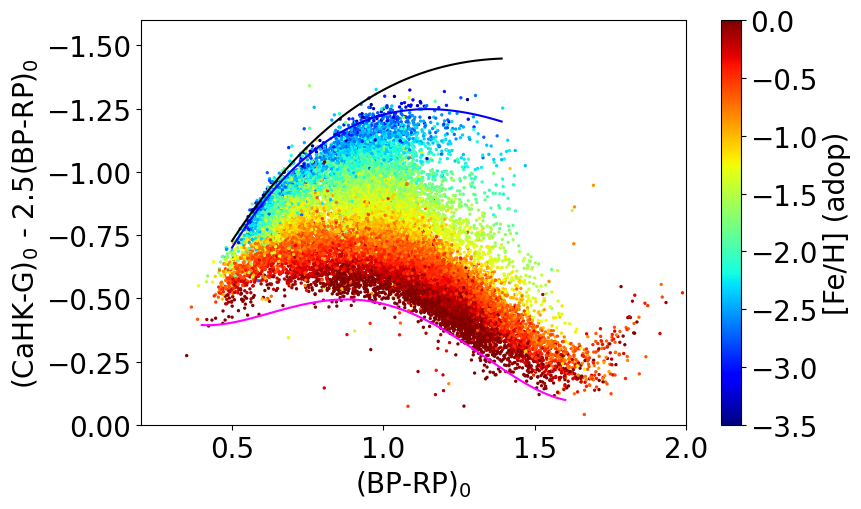

dwarfs with [Fe/H] < -2
----
3863
N(Aguado19) = 312
N(SDSS) = 2277
N(PristineHR) = 33
N(LAMOST) = 1199
N(pastel) = 42
----


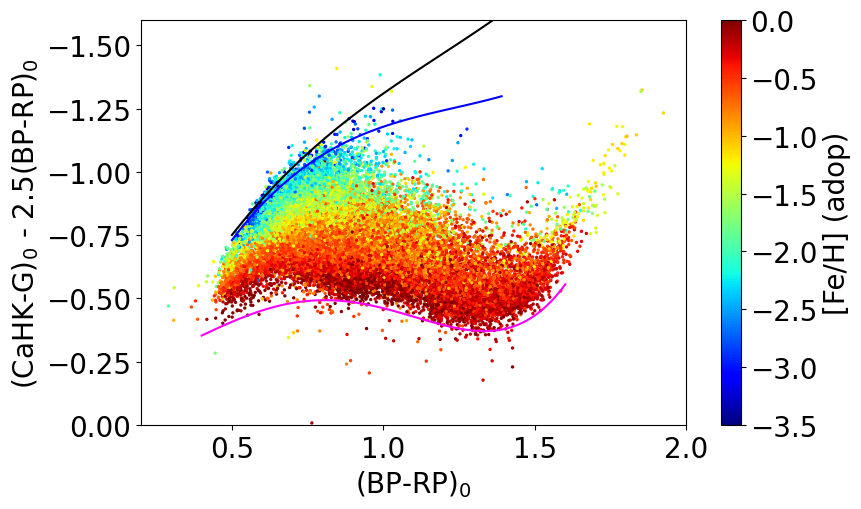

In [42]:
for subset in ['giants','dwarfs']:
    
    print(subset, 'with [Fe/H] < -2')
    
    print('----')
    
    ## get data
    TSsel1 = pd.read_csv(train_all[:-4]+'+CaHK_{}.csv'.format(subset))
    TSsel1 = TSsel1.sample(frac=1)
    
    print(len(TSsel1[TSsel1.feh_lit < -2.0]))
    
    ## print how many VMP stars per survey
    for suv in TSsel1.survey_neverempty.unique():
        TSselX = TSsel1[(TSsel1.survey_neverempty == suv) & (TSsel1.feh_lit < -2.0)]
        print('N({}) ='.format(suv), len(TSselX))
        
    print('----')
        
    ## Define grid 
    xplot_gi = TSsel1['BP_0'] - TSsel1['RP_0']
    yplot_gi = (TSsel1['CaHK_0'] - TSsel1['G_0']) - (bf)*(TSsel1['BP_0'] - TSsel1['RP_0'])
    fehplot = TSsel1['feh_lit']

    ## Define the zero-metallicity (ybb) and [Fe/H] = -3.0 (y3) lines
    xxs = np.arange(0.5, 1.4, 0.01)
    
    if (subset == 'all') | (subset == 'dwarfs'):
        ybb_gi = (0.346945 - 3.19276*xxs + 1.85539*xxs**2 - 0.519518*xxs**3 - (bf-2.7)*xxs)
        y3_gi = (0.613234 - 4.18968*xxs + 3.01172*xxs**2 - 0.813665*xxs**3 - (bf-2.7)*xxs)
    elif subset == 'giants':
        ybb_gi = (0.587261 - 3.70764*xxs + 1.92016*xxs**2 - 0.323654*xxs**3 - (bf-2.7)*xxs)
        y3_gi = (0.836432 - 4.55978*xxs + 2.84748*xxs**2 - 0.549882*xxs**3 - (bf-2.7)*xxs)

    ## Plot
    plt.figure(figsize=(9,5.5))
    plt.scatter(xplot_gi, yplot_gi, c=fehplot, vmin=-3.5, vmax=0.0, cmap='jet', s=2, rasterized=True)
    plt.colorbar(label='[Fe/H] (adop)')
    
    plt.plot(xxs, y3_gi, color='blue')
    plt.plot(xxs, ybb_gi, color='black')
    
    plt.xlim(0.2, 2.0)
    # plt.ylim(-0.6, 1.5)
    plt.ylim(-1.6, 0.0)
    
    ## get and plot solar metallicity line +0.1 dex (used to assign stars at the bottom edge of the grid feh = 0)
    xs = np.arange(0.4, 1.6, 0.01)
    ppar = np.loadtxt('../poly/polypar_0.0_{}BPRP_{}.txt'.format(round(bf,1),subset))
    pol = np.poly1d(ppar)
    plt.plot(xs, pol(xs)+0.1, color='magenta')

    plt.xlabel('(BP-RP)$_0$')
    plt.ylabel('(CaHK-G)$_0$ - {}(BP-RP)$_0$'.format(round(bf,1)))
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    plt.show()